# Prediction Olympics

Train a k-nearest neighbors algorithm to classify the sport (Athletics or Swimming) of olympic athletes using their age, sex, weight, and team.

Documentation and Sources:
- [Olympic data](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/version/2)
- [K-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.get_params)
- [Train-Test Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [1]:
# import libraries

# essentials
import numpy as np
import pandas as pd

# modeling
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Interpreting
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
import itertools

# visualizing
%matplotlib inline
from IPython.display import display, Markdown, Latex
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

/Users/elizastarr/.local/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/claudio/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/claudio/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/claudio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/claudio/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/claudio/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

In [2]:
# read in data

# ath holds the data about the athletes and their competitions
ath = pd.read_csv("data/athlete_events.csv", index_col=False, header=0, 
                  names=['ath_id', 'name', 'sex', 'age', 'height', 'weight', 
                         'team', 'noc', 'games', 'year', 'season', 'city', 
                         'sport', 'event', 'medal'])

# regions provides the corresponding contries of the National Olympic Committees (NOC)
# we don't need to use this until the interpretation stage
regions = pd.read_csv("data/noc_regions.csv") 

In [3]:
# rename the index column
# this is a unique id for each competition instance

ath.index.name = 'id'

## Explore and Clean

#### Summary statistics

In [4]:
# we have 271116 instances and 15 features

ath.shape

(271116, 15)

In [5]:
# what the data looks like

ath.head()

,ath_id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
id,,,,,,,,,,,,,,,
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [6]:
# the pandas_profiling library provides useful summaries of your data

profile = pandas_profiling.ProfileReport(ath)
rejected_variables = profile.get_rejected_variables(threshold=0.9) # empty

profile

Number of variables,15
Number of observations,271116
Total Missing (%),8.9%
Total size in memory,31.0 MiB
Average record size in memory,120.0 B
Numeric,5
Categorical,10
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### Dealing with missing values

In [7]:
# replace nan in medal column with "No" 
# nan actually means that the athlete did not place, not that their placement is unknown

ath['medal'].fillna("No", inplace=True)

In [8]:
# we still have missing values
# age 3.5%, height 22.2%, and weight 23.2%
# does this correlate with year?

nan = ath[ath.isnull().any(axis=1)]
age_nan = ath[ath['age'].isnull()]
height_nan = ath[ath['height'].isnull()]
weight_nan = ath[ath['weight'].isnull()]

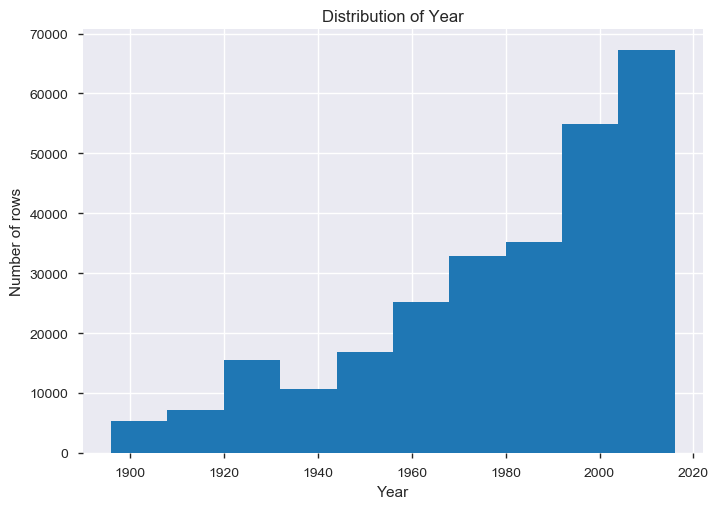

In [9]:
# what is the distribution of year before removing non-null values?
# the more recent the year, the more instances.

plt.hist(ath['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows')
plt.title('Distribution of Year')
plt.grid(True)
plt.show()

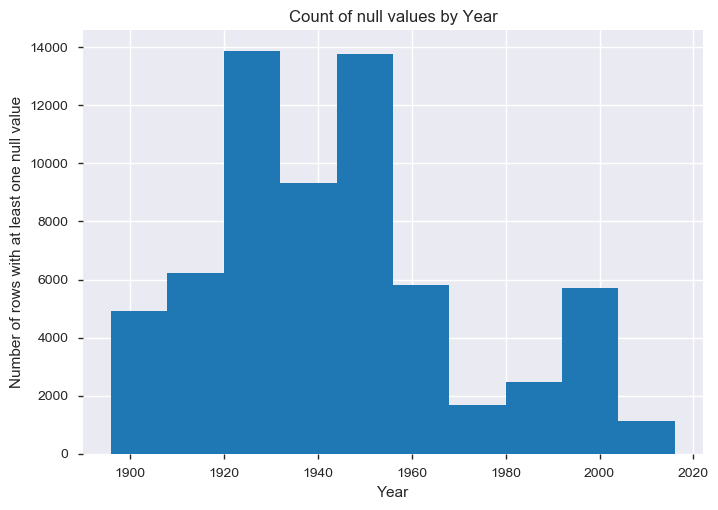

In [10]:
# what is the distribution of null values by Year?
# recent years have fewer null values, despite there being more entries for recent years

plt.hist(nan['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows with at least one null value')
plt.title('Count of null values by Year')
plt.grid(True)
plt.show()

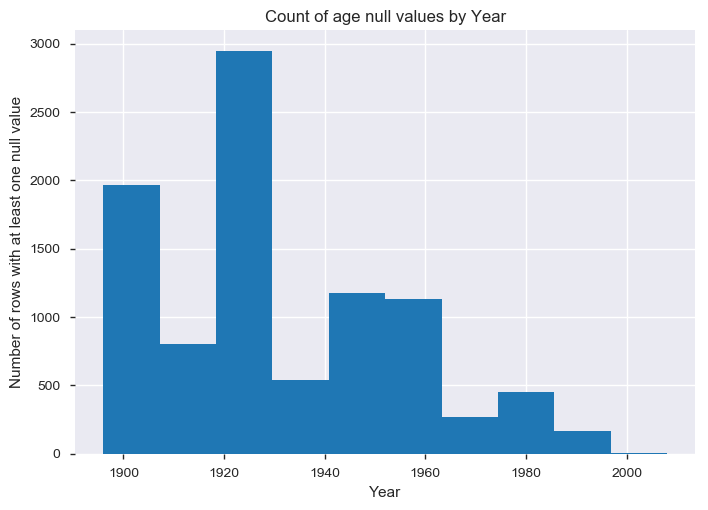

In [11]:
# what is the distribution of age null values by Year?
# recent years have fewer null values, despite there being more entries for recent years

plt.hist(age_nan['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows with at least one null value')
plt.title('Count of age null values by Year')
plt.grid(True)
plt.show()

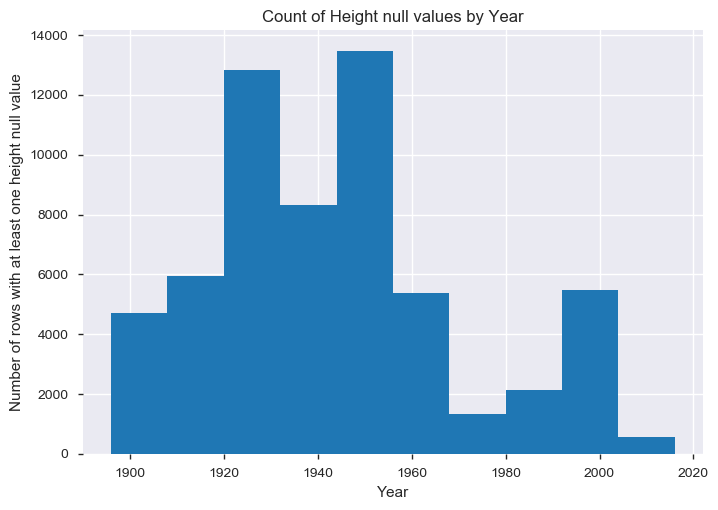

In [12]:
# what is the distribution of height null values by Year?
# recent years have fewer null values, despite there being more entries for recent years

plt.hist(height_nan['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows with at least one height null value')
plt.title('Count of Height null values by Year')
plt.grid(True)
plt.show()

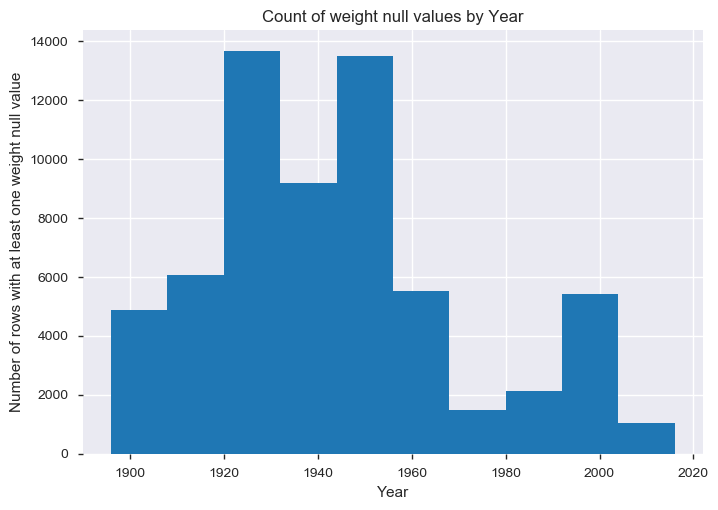

In [13]:
# what is the distribution of age null values by Year?
# recent years have fewer null values, despite there being more entries for recent years
# this histogram looks very similar to that of height. 
# Perhaps if an athlete's height is missing, their weight is also missing.

plt.hist(weight_nan['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows with at least one weight null value')
plt.title('Count of weight null values by Year')
plt.grid(True)
plt.show()

In [14]:
# how should we deal with these missing values?
# drop NaN

ath_drop = ath.dropna(axis=0, how="any")
ath_drop.shape

(206165, 15)

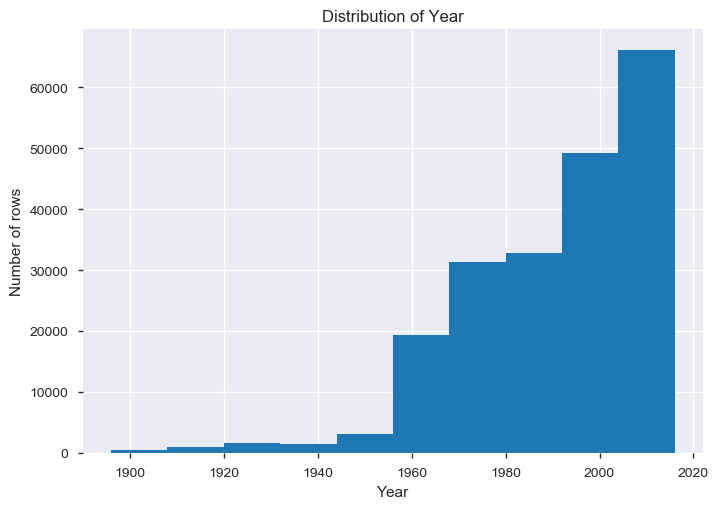

In [15]:
# how does dropping null values affect the year distribution?
# we have way less older instances, especially before 1960

plt.hist(ath_drop['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows')
plt.title('Distribution of Year')
plt.grid(True)
plt.show()

In [16]:
# exactly how many instances per year, sorted in ascending order?
# let's cut out years before 1950, when we break 2000 instances.

ath_drop.groupby('year').count()[['ath_id']].sort_values('ath_id').head(20) # only the lowest 20 years

,ath_id
year,
1896,40
1900,71
1904,119
1906,201
1908,366
1920,428
1932,492
1912,551
1924,582


In [17]:
# drop rows from years before 1950 because we have too few samples from those years

ath_clean = ath_drop.drop(ath_drop.loc[ath_drop['year'] < 1950].index)

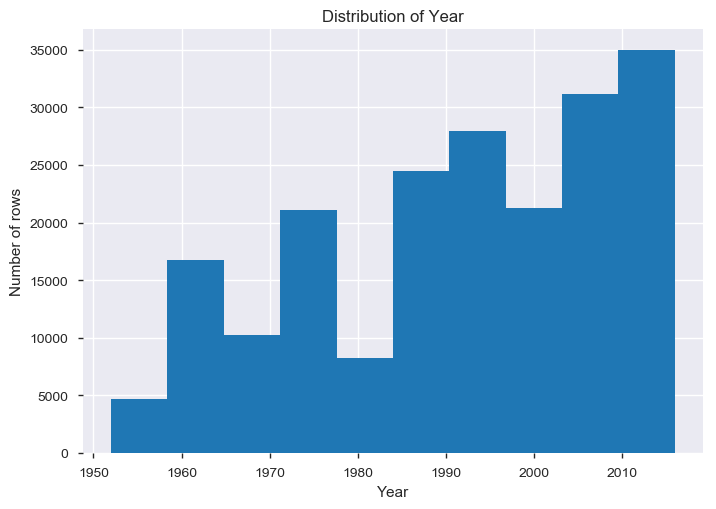

In [18]:
# how does the distribution look now?

plt.hist(ath_clean['year'])
plt.xlabel('Year')
plt.ylabel('Number of rows')
plt.title('Distribution of Year')
plt.grid(True)
plt.show()

#### Feature relationships

In [19]:
# there is an inverse correlation between height and weight. Keep this in mind.

In [20]:
# here I check that each sport category has only one season

ath_clean.groupby(['sport','season']).count()

,,ath_id,name,sex,age,height,weight,team,noc,games,year,city,event,medal
sport,season,,,,,,,,,,,,,
Alpine Skiing,Winter,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Archery,Summer,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883
Athletics,Summer,28755,28755,28755,28755,28755,28755,28755,28755,28755,28755,28755,28755,28755
Badminton,Summer,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362,1362
Baseball,Summer,846,846,846,846,846,846,846,846,846,846,846,846,846
Basketball,Summer,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598
Beach Volleyball,Summer,538,538,538,538,538,538,538,538,538,538,538,538,538
Biathlon,Winter,4615,4615,4615,4615,4615,4615,4615,4615,4615,4615,4615,4615,4615
Bobsleigh,Winter,2194,2194,2194,2194,2194,2194,2194,2194,2194,2194,2194,2194,2194


In [21]:
# drop season because it is not an interesting variable to us

ath_clean.drop('season', axis=1, inplace=True)

In [22]:
# what is the relationship between noc and team
# one to many: one noc to many teams
# we can generalize teams into noc

ath_clean.groupby(['noc','team']).count().head(30)

ath_id  name   sex   age  height  weight  games  \
noc team                                                                    
AFG Afghanistan               54    54    54    54      54      54     54   
AHO Netherlands Antilles      51    51    51    51      51      51     51   
ALB Albania                   57    57    57    57      57      57     57   
ALG Algeria                  481   481   481   481     481     481    481   
AND Andorra                  135   135   135   135     135     135    135   
ANG Angola                   245   245   245   245     245     245    245   
ANT Antigua and Barbuda      115   115   115   115     115     115    115   
ARG Ardilla                    3     3     3     3       3       3      3   
    Argentina               2105  2105  2105  2105    2105    2105   2105   
    Argentina-1                8     8     8     8       8       8      8   
    Argentina-2                8     8     8     8       8       8      8   
    Mizar                      2     2     2     2       2       2      2   
    Pampero                    5     5     5     5       5       5      5   
    Rampage                    2     2     2     2       2       2      2   
    Tango                      6     6     6     6       6       6      6   
ARM Armenia                  205   205   205   205     205     205    205   
ARU Aruba                     41    41    41    41      41      41     41   
ASA American Samoa            21    21    21    21      21      21     21   
AUS Australia               6453  6453  6453  6453    6453    6453   6453   
    Australia-1               39    39    39    39      39      39     39   
    Australia-2               38    38    38    38      38      38     38   
    Australia-3                2     2     2     2       2       2      2   
    Barrenjoey                 3     3     3     3       3       3      3   
    Buraddoo                   4     4     4     4       4       4      4   
    Cambria                    3     3     3     3       3       3      3   
    Diablo                     2     2     2     2       2       2      2   
    Falcon IV                  1     1     1     1       1       1      1   
    Falcon VI                  2     2     2     2       2       2      2   
    Gabbiano                   3     3     3     3       3       3      3   
    Greenoaks Dundee           1     1     1     1       1       1      1   

                          year  city  sport  event  medal  
noc team                                                   
AFG Afghanistan             54    54     54     54     54  
AHO Netherlands Antilles    51    51     51     51     51  
ALB Albania                 57    57     57     57     57  
ALG Algeria                481   481    481    481    481  
AND Andorra                135   135    135    135    135  
ANG Angola                 245   245    245    245    245  
ANT Antigua and Barbuda    115   115    115    115    115  
ARG Ardilla                  3     3      3      3      3  
    Argentina             2105  2105   2105   2105   2105  
    Argentina-1              8     8      8      8      8  
    Argentina-2              8     8      8      8      8  
    Mizar                    2     2      2      2      2  
    Pampero                  5     5      5      5      5  
    Rampage                  2     2      2      2      2  
    Tango                    6     6      6      6      6  
ARM Armenia                205   205    205    205    205  
ARU Aruba                   41    41     41     41     41  
ASA American Samoa          21    21     21     21     21  
AUS Australia             6453  6453   6453   6453   6453  
    Australia-1             39    39     39     39     39  
    Australia-2             38    38     38     38     38  
    Australia-3              2     2      2      2      2  
    Barrenjoey               3     3      3      3      3  
    Buraddoo                 4     4      4      4      4  
 

In [23]:
# games combines the year and city
# these are our time features
# let's ignore these

ath_clean[['games', 'year', 'city']].head()

,games,year,city
id,,,
0,1992 Summer,1992,Barcelona
1,2012 Summer,2012,London
4,1988 Winter,1988,Calgary
5,1988 Winter,1988,Calgary
6,1992 Winter,1992,Albertville


In [24]:
# what is the relationship between sport and event?
# one to many: one sport to many events
# we can generalize event with sport

ath_clean.groupby(['sport','event']).count()[['ath_id']].head()

ath_id
sport         event                                   
Alpine Skiing Alpine Skiing Men's Combined         382
              Alpine Skiing Men's Downhill         751
              Alpine Skiing Men's Giant Slalom    1045
              Alpine Skiing Men's Slalom          1035
              Alpine Skiing Men's Super G          475

#### Duplicate athletes
This is important because if we leave certain duplicates, we risk training the model with the same data we test it with thereby inflating the prediction power.

In [25]:
# How many individuals are in the dataset? 
# NOTE: one athlete can participate in many olympics
# 96,521 individuals

ath_clean.groupby(['ath_id']).count().shape

(96521, 13)

In [26]:
# How many are left when you drop duplicate instances for the same games? 
# NOTE: some athletes participate in multiple events and sports at the same olympic game
# 141,920 individuals are left

ath_clean.groupby(['ath_id', 'games','sport']).count().shape

(141920, 11)

In [27]:
# let's drop duplicate instances where an athlete participated in multiple events in the same sport and game

ath_clean.drop_duplicates(['ath_id','games','sport'], keep="first", inplace=True)

## Model

In [28]:
# again, these are our features
# interesting varibles are:'sex', 'age', 'height', 'weight', 'noc', 'team,' 'sport', 'event', 'medal'

ath_clean.columns

Index(['ath_id', 'name', 'sex', 'age', 'height', 'weight', 'team', 'noc',
       'games', 'year', 'city', 'sport', 'event', 'medal'],
      dtype='object')

#### What should we predict?
Let's predict the sport by sex, age, height or weight, and noc or team

Label:
* sport - categorical

Predictors:
* sex - categorical, binary
* age - numeric, in years
* height - numeric, in centimeters. correlated with weight
* weight - numeric, in kilogram
* noc - categorical

In [29]:
# how many unique sports are there to classify

ath_clean['sport'].nunique()

51

In [30]:
# because there are so many sports, let's narrow down how many we classify
# Athletics and Swimming have the most instances. Let's go with these.
# however, this dataset is not balanced now so it may be better at classifying athletics than swimming

ath_clean.groupby('sport').count().sort_values('ath_id', ascending=False)[['ath_id']].head(10)

,ath_id
sport,
Athletics,23951
Swimming,9259
Rowing,7470
Cycling,5775
Shooting,5413
Wrestling,4918
Sailing,4809
Ice Hockey,4489
Boxing,4302


In [70]:
# filter for just these sports

ath_filter = ath_clean[ath_clean['sport'].isin(['Athletics', 'Swimming'])]

In [71]:
# now that our dataframe is unbalanced, we need to balance it
# sample the "Athletics"-labeled data so that we have the same # of instances for both labels

g = ath_filter.groupby('sport')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True))
ath_filter = g.copy()

In [72]:
# how small is our dataset now? 
# This is a pretty small

ath_filter.shape

(18518, 14)

#### Time to choose an algorithm
Let's try k-nearest neighbors

# Sammy: motivation for k-nearest neighbors

In [73]:
# convert the string variables into numerical variables (still categorical)

le = LabelEncoder()

# F=0, M=1
ath_filter.loc[:,'sex_num'] = le.fit_transform(ath_filter['sex'])
ath_filter.loc[:,'noc_num'] = le.fit_transform(ath_filter['noc'])
# Athletics=0, Swimming=1
ath_filter.loc[:,'sport_num'] = le.fit_transform(ath_filter['sport'])
ath_filter.loc[:,'team_num'] = le.fit_transform(ath_filter['team'])

In [74]:
# divide data into training (2/3) and testing (1/3)
# predictors are sex, age, weight, and noc
# weight seems to have slightly more predictive power than height

X_train, X_test, y_train, y_test = train_test_split(ath_filter[['sex_num','age','weight','noc_num']], 
                                                    ath_filter['sport_num'], 
                                                    test_size=0.33, 
                                                    random_state=42)

In [75]:
# create classifier instance and define the parameters for GridSearchCV to try

knn = KNeighborsClassifier(algorithm="auto")
params = {"n_neighbors": [1,2,3,4,5,6]}

In [76]:
# create the GridSearchCV and fit it to the data
# using 3-fold cross validation
# the estimator varable records the highest performing parameters

grid = GridSearchCV(knn, params, cv=3, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [77]:
# detailed results from cross validation for each n in [1,2,3,4,5,6]

pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.008353,0.002103,0.012472,0.001317,1,{'n_neighbors': 1},0.702853,0.693665,0.697703,0.698074,0.003760,5,0.974489,0.973401,0.972437,0.973442,0.000838
1,0.006354,0.000111,0.012378,0.000038,2,{'n_neighbors': 2},0.693424,0.690764,0.695042,0.693076,0.001764,6,0.853464,0.857454,0.847195,0.852704,0.004222
2,0.006119,0.000132,0.013593,0.000013,3,{'n_neighbors': 3},0.729207,0.723404,0.731076,0.727896,0.003266,3,0.852497,0.854310,0.849371,0.852059,0.002040
3,0.006709,0.000801,0.015126,0.000146,4,{'n_neighbors': 4},0.727031,0.718810,0.726481,0.724107,0.003752,4,0.823117,0.822996,0.819391,0.821835,0.001729
4,0.006375,0.000221,0.017863,0.001468,5,{'n_neighbors': 5},0.734284,0.736944,0.742926,0.738051,0.003614,1,0.817676,0.823480,0.815643,0.818933,0.003320
5,0.008369,0.001794,0.020839,0.002724,6,{'n_neighbors': 6},0.738878,0.731867,0.740508,0.737084,0.003749,2,0.804981,0.817314,0.806456,0.809583,0.005499


In [78]:
# What is the mean accuracy on the given test data and labels?

grid.score(X_test, y_test)

0.7378497790868925

In [79]:
# record the predictions make on the test data for interpretation

predictions = grid.predict(X_test)

## Interpret
Use accuracy, precision, recall, f1 metrics and a normalized confusion matrix to visualize the results.

In [80]:
# define helper functions

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

In [81]:
# What are the accuracy, precision, recall, f1 scores?

accuracy, precision, recall, f1 = get_metrics(y_test, predictions)
print("accuracy = %.2f, precision = %.2f, recall = %.2f, f1 = %.2f" % (accuracy, precision, recall, f1))

accuracy = 0.74, precision = 0.74, recall = 0.74, f1 = 0.74


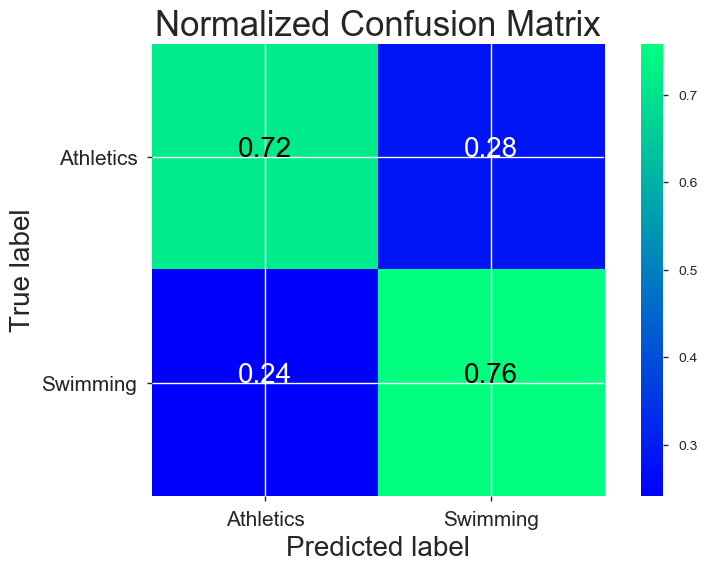

In [82]:
# Let's visualize these variables and break it down by sport
# As predicted, the classifier is 

cm = confusion_matrix(y_test, predictions)

plt.figure()
plot_confusion_matrix(cm, classes=['Athletics','Swimming'], normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()

# Sammy: further discussion of results